# <center> <b> <font color='blue'> BITCOIN PREDICTION </center> </b> </font>

## <font color='#1f618d'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Making a multivariate time series](#4)
5. [Pre-processing](#5)
6. [Models](#6) <br>
    6.1. [Dense Model](#6.1)<br>
    6.2. [LSTM](#6.2)<br>
7. [References](#References)

<a name="1"></a>
## <font color='#1f618d'> <b> 1. Introduction </font> </b>


If predicting the price of Bitcoin using only the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.


This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

> 🔑 **Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

<a name="2"></a>
## <font color='#1f618d'> <b> 2. Setup </font> </b>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [87]:
# Set global print options to display 2 decimal places
np.set_printoptions(precision=2, suppress=True)

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Helper Functions </font> </b>

### Plots

In [54]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
def plot_time_series(df):
    """
    args: df with price and block_reward
    """
    scaled_df = pd.DataFrame(minmax_scale(df[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=df.columns,
                                     index=df.index)
    scaled_df.plot(figsize=(8, 5));
    

    
    
# plot history
def plot_history(history):

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot MAE
    ax1.plot(history.history['mae'], label='Train MAE')
    ax1.plot(history.history['val_mae'], label='Validation MAE')
    ax1.set_title('Mean Absolute Error (MAE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MAE')
    ax1.legend()

    # Plot MSE
    ax2.plot(history.history['mse'], label='Train MSE')
    ax2.plot(history.history['val_mse'], label='Validation MSE')
    ax2.set_title('Mean Squared Error (MSE)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Display plots
    plt.tight_layout()
    plt.show()


### Train/Test split

In [4]:
def train_test_split(data, split_size=0.8):
    """
    Splits time series data into training and testing sets based on a specified split ratio,
    preserving the temporal order of the data.

    Parameters
    ----------
    data : pandas.DataFrame or pandas.Series
        The time series data with a timestamp index to be split.
    split_size : float, optional
        The proportion of data to use for the training set. Default is 0.8 (80% train, 20% test).

    Returns
    -------
    tuple
        A tuple containing:
        - train_data (numpy.ndarray): The training set values.
        - test_data (numpy.ndarray): The testing set values.
        - train_timestamps (pandas.Index): Timestamps corresponding to the training set.
        - test_timestamps (pandas.Index): Timestamps corresponding to the testing set.

    Examples
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> index = pd.date_range(start="2022-01-01", periods=10, freq="D")
    >>> data = pd.Series(np.random.rand(10), index=index)
    >>> train_data, test_data, train_timestamps, test_timestamps = train_test_split(data, split_size=0.7)
    """
    # Determine the split point based on the test size
    split_point = int(len(data) * split_size)

    # Split the data into training and testing sets, preserving time order
    train_data = data[:split_point].values
    test_data = data[split_point:].values

    # Extract the timestamps for training and testing sets
    train_time = data.index[:split_point]
    test_time = data.index[split_point:]
    
    return train_data, test_data, train_time, test_time


### Windowing

In [5]:
def windowed_dataset(data, window_size, batch_size, shuffle_buffer, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Create sliding windows of size window_size + 1 (for the label)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset and create feature/label pairs
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Features: previous 5 values of both T and h (columns 0 and 1 respectively)
    # Target: next temperature value (T at t+1, column 0 of the last row in the window)
    dataset = dataset.map(lambda window: (window[:-1, :], window[-1, 0]))  
            # 'window[:-1, :]' gets 5 values of T and the others features, 'window[-1, 0]' gets T(t+1)
    
    # Shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


### Predictions

In [79]:
def forecast(model, initial_window, num_predictions, verbose=False):
    """
    Function to forecast predictions on a multivariate time series dataset, 
    where the first feature moves and the second feature remains fixed.

    Parameters:
    - model: Trained model used for forecasting.
    - initial_window: The initial input window (multivariate time series).
    - num_predictions: The number of steps to predict.
    - verbose: If True, prints additional information during predictions.

    Returns:
    - np.array: Array of predicted values for the forecasted steps.
    """
    
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for one step ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_step = pred[0][0]  # Extract the predicted step (first feature)

        # Log predictions if verbose is True
        if verbose:
            print(f"Predicting on: \n {current_window} -> Prediction: {pred_step}\n")

        # Add the prediction to the list
        predictions.append(pred_step)

        # Update the window: shift the first feature and keep the second feature fixed
        current_window = np.roll(current_window, -1, axis=0)  # Shift rows to the left
        current_window[-1, 0] = pred_step  # Insert the new prediction in the first feature column

        # The second feature (index 1) stays fixed, no need to change it

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


### Evaluation

In [7]:
# single horizon
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)


    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

<a name="4"></a>
## <font color='#1f618d'> <b> 4. Making a multivariate time series </font> </b>

In [8]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [9]:
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [10]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [11]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to obtain the days (indexes) for different block reward values.

This is important because if we're using multiple variables for our time series, they need to have the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

🔑 Note: When using multiple variables, make sure they have the same frequency as each other. If your variables aren't at the same frequency (e.g., Bitcoin prices are daily, but block rewards are weekly), you may need to transform them so they can be used with your model.

In [12]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [13]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [14]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [15]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


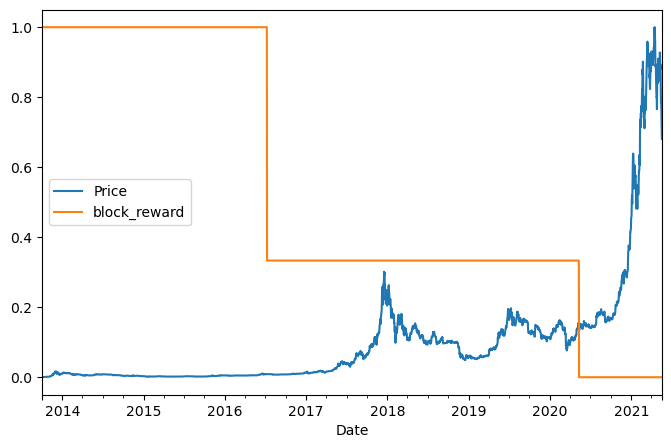

In [16]:
plot_time_series(bitcoin_prices_block)

<a name="5"></a>
## <font color='#1f618d'> <b> 5. Pre-processing </font> </b>

In [17]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

#### Train/Test Split

In [18]:
train_data, val_data, train_time, test_time = train_test_split(bitcoin_prices_block, 0.8)
len(train_data), len(val_data), len(train_time), len(test_time)

(2229, 558, 2229, 558)

In [19]:
train_data[:3]

array([[123.65499, 25],
       [125.455, 25],
       [108.58483, 25]], dtype=object)

In [20]:
train_time[:3]

DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03'], dtype='datetime64[ns]', name='Date', freq=None)

#### Windowing

Let's test our windowing function with a window size of 2 and a batch_size=1 to see more clearly what it does.

In [21]:
aux = windowed_dataset(train_data.astype(np.float32), 2, 1, 32, False)

In [22]:
train_data[:5]

array([[123.65499, 25],
       [125.455, 25],
       [108.58483, 25],
       [118.67466, 25],
       [121.33866, 25]], dtype=object)

In [23]:
for x,y in aux.take(3):
    print(f"X: {x}\n y: {y} \n\n")

X: [[[123.65499  25.     ]
  [125.455    25.     ]]]
 y: [108.58483] 


X: [[[125.455    25.     ]
  [108.58483  25.     ]]]
 y: [118.67466] 


X: [[[108.58483  25.     ]
  [118.67466  25.     ]]]
 y: [121.33866] 




Now, let's try with a "more in the middle" values to see if it's moving the block reward appropiately:

In [34]:
train_data[1010:1015]

array([[671.814, 25],
       [640.476, 25],
       [654.85299, 12.5],
       [649.356, 12.5],
       [656.747, 12.5]], dtype=object)

In [35]:
subset = aux.skip(1010).take(3)
for x,y in subset.take(3):
    print(f"X: {x}\n y: {y} \n\n")


X: [[[671.814  25.   ]
  [640.476  25.   ]]]
 y: [654.85297] 


X: [[[640.476    25.     ]
  [654.85297  12.5    ]]]
 y: [649.356] 


X: [[[654.85297  12.5    ]
  [649.356    12.5    ]]]
 y: [656.747] 




Finally let's apply this function to the train and validation sets with more appropiate values:

In [36]:
ds_train = windowed_dataset(train_data.astype(np.float32),WINDOW_SIZE, 32, 1000) 
ds_val = windowed_dataset(val_data.astype(np.float32), WINDOW_SIZE, 32, 1000, False)

<a name="6"></a>
## <font color='#1f618d'> <b> 6. Models </font> </b>

In [37]:
tf.random.set_seed(42)

In [38]:
NUM_FEATURES = train_data.shape[1]
NUM_FEATURES

2

<a name="6.1"></a>
### <font color='#2471a3'> <b> 6.1. Dense Model </font> </b>

In [42]:
def build_compile_model_1(name, window_size=WINDOW_SIZE, horizon=HORIZON, num_features=NUM_FEATURES):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(window_size, num_features)),  
                    # input_shape should match your features
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(horizon)
    ], name=name)
    
    model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['mae','mse']
    )
    
    return model


model_1 = build_compile_model_1('Dense_Model')
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 7, 128)            384       
                                                                 
 dense_7 (Dense)             (None, 7, 64)             8256      
                                                                 
 flatten_2 (Flatten)         (None, 448)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 449       
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# fit
history_1 = model_1.fit(
    ds_train, 
    epochs=50, 
    verbose=0,
    validation_data=ds_val)

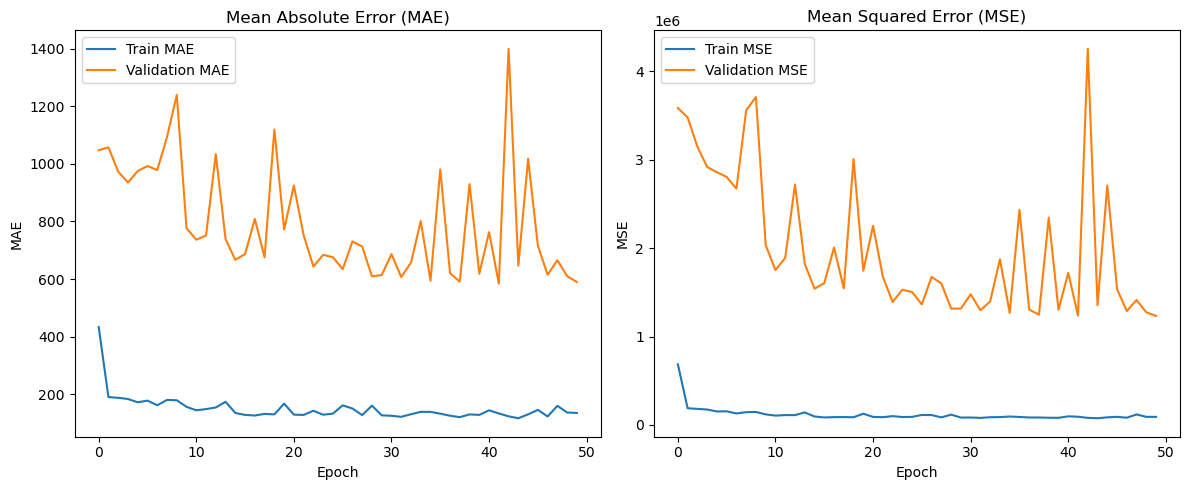

In [55]:
plot_history(history_1)

In [56]:
model_1.evaluate(ds_val)

18/18 [==============================] - 0s 3ms/step - loss: 1232475.1250 - mae: 589.6697 - mse: 1232475.1250


[1232475.125, 589.669677734375, 1232475.125]

#### Making predictions

In [84]:
# first, let's choose an initial window
for x, _ in ds_val.take(-1):
    initial_window = x.numpy()[-1]

initial_window, initial_window.shape

(array([[5.57e+04, 6.25e+00],
        [5.66e+04, 6.25e+00],
        [5.21e+04, 6.25e+00],
        [4.98e+04, 6.25e+00],
        [5.00e+04, 6.25e+00],
        [4.79e+04, 6.25e+00],
        [4.56e+04, 6.25e+00]], dtype=float32),
 (7, 2))

In [88]:
forecast(model_1, initial_window, 3, verbose=True)

Predicting on: 
 [[55715.55     6.25]
 [56573.55     6.25]
 [52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]] -> Prediction: 45966.03125

Predicting on: 
 [[56573.55     6.25]
 [52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]
 [45966.03     6.25]] -> Prediction: 45405.38671875

Predicting on: 
 [[52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]
 [45966.03     6.25]
 [45405.39     6.25]] -> Prediction: 45233.39453125



array([45966.03, 45405.39, 45233.39], dtype=float32)

We can see that it keeps the second value fixed (we only predict the bitcoin price).

### Forecasting approach (updating one feature while keeping the other feature fixed)


#### Key Points to Consider:

#### 1. Model Dependency:

- If your model is designed to predict based on all features (multivariate), then it typically expects that all features are updated in the forecast. However, you are fixing one of the features, which can be appropriate if your task explicitly requires this behavior (e.g., forecasting based on historical data of one feature while keeping another feature constant).
- If the model is trained with both features moving together in the training data, and you want to predict only one feature (while holding the other constant), the approach makes sense, but the prediction accuracy may depend on how well the model generalizes when only one feature is updated.

#### 2. Autoregressive Process:

- The method you are using is a common approach in autoregressive models (e.g., ARIMA, LSTM). The idea is to iteratively forecast the next value based on previous predictions. By keeping the second feature fixed and only predicting the first one, you're essentially modeling a univariate time series prediction for the first feature, while using the second feature as a "context" or additional information.

#### 3. Data Representation:

- You are assuming that the time series data for both features is related, and this relationship might hold even if the second feature is fixed. If the second feature is truly static (e.g., a constant feature or a known parameter), this makes sense. However, if the second feature is dynamic and has some impact on the first feature (even if it's not explicitly used in the prediction), keeping it constant might limit the model’s ability to make accurate predictions.

#### 4. Model Forecasting Behavior:

- If the model was trained on both features (i.e., multivariate input) and you forecast only the first feature, you need to ensure that the model can handle this scenario effectively. In some cases, models like LSTM or GRU can still work reasonably well by conditioning on a fixed value for the second feature, but this may not be optimal if the relationship between the features is strong and dynamic.

#### 5. Alternatives:

- **Simultaneous Forecasting:** If the relationship between features is strong, you might want to forecast both features simultaneously (both features moving forward with the model predicting both at each time step). This approach would involve updating both features, not just the first one.

- **Separate Forecasting:** If you want to predict the first feature but the second feature might still affect it in some way (e.g., the second feature has some known pattern), you could consider forecasting each feature separately or use a model that allows for partial dependencies.

#### 6. Improving Your Approach:

- **Include a "Fixed" Feature as a Condition:** If you're using a neural network, you can explicitly pass the second feature as part of the model's input, ensuring it can still "see" the second feature and use it in the predictions, even if you don’t update it during the forecast.

- **Hybrid Models:** Another option is to use a hybrid model that forecasts the first feature and updates the second feature based on the context, if necessary.




<a name="6.2"></a>
### <font color='#2471a3'> <b> 6.2. LSTM </font> </b>

We are going to use a bigger window size in here.

In [106]:
HORIZON = 1
WINDOW_SIZE = 20

ds_train = windowed_dataset(train_data.astype(np.float32),WINDOW_SIZE, 32, 1000) 
ds_val = windowed_dataset(val_data.astype(np.float32), WINDOW_SIZE, 32, 1000, False)

In [119]:
def build_compile_model_2(name, window_size=WINDOW_SIZE, horizon=HORIZON, num_features=NUM_FEATURES):
    model = tf.keras.Sequential(name=name)

    # LSTM Layer to handle time series input
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, num_features)))
    model.add(tf.keras.layers.LSTM(64))

    # Dense layers
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dense(horizon))


    # Compile the model
    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae','mse'])

    return model


model_2 = build_compile_model_2('LSTM')
model_2.summary()



Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 20, 64)            17152     
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 54401 (212.50 KB)
Trainable params: 54401 (212.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # Metric to monitor (could also use 'val_accuracy')
    patience=10,                  # Number of epochs to wait for improvement
    verbose=1,                    # Print a message when stopping
    restore_best_weights=True     # Restore the best model weights when stopping
)

# fit
history_2 = model_2.fit(
    ds_train, 
    epochs=50, 
    verbose=0,
    validation_data=ds_val,
    callbacks=[early_stopping])

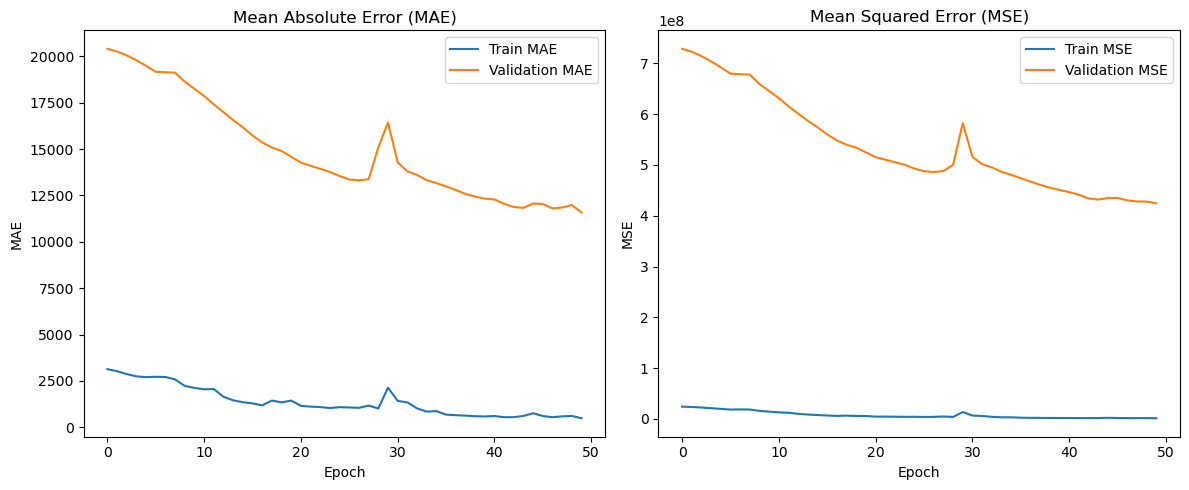

In [121]:
plot_history(history_2)

In [122]:
model_2.evaluate(ds_val)

17/17 [==============================] - 0s 5ms/step - loss: 424466240.0000 - mae: 11582.2588 - mse: 424466240.0000


[424466240.0, 11582.2587890625, 424466240.0]

#### Predictions

In [125]:
# first, let's choose an initial window
for x, _ in ds_val.take(-1):
    initial_window = x.numpy()[-1]

initial_window.shape

(20, 2)

In [129]:
forecast(model_2, initial_window, 2, verbose=True)

Predicting on: 
 [[55123.86     6.25]
 [54591.52     6.25]
 [53260.3      6.25]
 [57302.64     6.25]
 [57677.98     6.25]
 [56427.04     6.25]
 [57255.31     6.25]
 [53658.84     6.25]
 [57252.7      6.25]
 [56583.85     6.25]
 [57107.12     6.25]
 [58788.21     6.25]
 [58102.19     6.25]
 [55715.55     6.25]
 [56573.55     6.25]
 [52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]] -> Prediction: 9852.25

Predicting on: 
 [[54591.52     6.25]
 [53260.3      6.25]
 [57302.64     6.25]
 [57677.98     6.25]
 [56427.04     6.25]
 [57255.31     6.25]
 [53658.84     6.25]
 [57252.7      6.25]
 [56583.85     6.25]
 [57107.12     6.25]
 [58788.21     6.25]
 [58102.19     6.25]
 [55715.55     6.25]
 [56573.55     6.25]
 [52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]
 [ 9852.25     6.25]] -> Prediction: 9852.2490234375



array([9852.25, 9852.25], dtype=float32)

<a name="References"></a>
## <font color='#1a5276'> <b> 7. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)